**OTUS Machine Learning Professional**

### **Homework 7**

### Building a recommendation system

![hw7p_header](https://user-images.githubusercontent.com/73858914/171977625-f8c473af-748f-4264-b024-5f4a484da8b2.png)

**Goals:**

1. Download a dataset from [Amazon review data](https://nijianmo.github.io/amazon/index.html "https://nijianmo.github.io/amazon/index.html");   
2. Explore data - distribution of ratings, number of unique items etc.;
3. Do time-aware train-test split;
4. Build a recommender system;
5. Estimate the system's quality with either RMSE or ratings

**Means**:

- Notebook relies mostly on [Surprise](https://github.com/NicolasHug/Surprise) and [TextHero](https://github.com/jbesomi/texthero/tree/master/texthero) libraries

**Data source**:

[Amazon Review Data (2018)](https://nijianmo.github.io/amazon/index.html)

**Binder notebook:**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/oort77/OTUS_PRO_HW7/main)

### Review positivity-negativity recommender 

We will try to build a recommender system that will calculate a sentiment   
for each rating.   Sentiment is calculated as normalised difference between   
positive and negative words occurences in each review+summary text.   
[Minqing Hu and Bing Liu](http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html) lexicon lists are used for positive/negative words.

### Import libraries

In [1]:
# import surprise
import pandas as pd
import numpy as np
from surprise import KNNWithMeans, KNNBaseline, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.accuracy import rmse
import random
import json
import gzip
import requests
import matplotlib.pyplot as plt
# import seaborn as sns
import texthero as hero
from IPython.display import display, HTML
import warnings

warnings.filterwarnings("ignore")

###  Miscellaneous settings

In [2]:
%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (10, 5)
plt.style.use('seaborn')
pd.options.display.precision = 4

### Load data

Please uncomment lines belowm if you run the notebook on colab or mybinder

In [3]:
# url = "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Tools_and_Home_Improvement_5.json.gz"
# r = requests.get(url)
# with open("./data/Tools_and_Home_Improvement_5.json.gz","wb") as gz_file:
#     gz_file.write(r.content)

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_ = getDF('./data/Tools_and_Home_Improvement_5.json.gz')

In [4]:
df_.tail()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
2070826,4.0,True,"03 7, 2017",A2Y0L6RLGE6AG0,B01HJCLMMQ,NaN,William R. Oldaker,I like it.,Four Stars,1488844800,NaN,NaN
2070827,5.0,True,"03 2, 2017",A31CQSAL2PI371,B01HJCLMMQ,NaN,Kenny L Nipp,Great task light. I travel extensively and con...,You can set the light to various conditions to...,1488412800,NaN,NaN
2070828,5.0,True,"01 7, 2017",A3PR3RT5QL5I3O,B01HJCLMMQ,NaN,J. Ro Morgan,"Very bright, beautifully packaged, light weigh...",I bought a second one...,1483747200,NaN,NaN
2070829,4.0,True,"04 17, 2018",A1LQ5376UESSM,B01HJF90LS,{'Color:': ' warm white'},Simon,"Clever replacement for a mason jar top, a sola...",Pretty - but nobody tells you the lights only ...,1523923200,NaN,NaN
2070830,2.0,True,"12 4, 2017",A1T9O7WJWI1XSR,B01HJHS73S,NaN,craig johnson,"Item still works, but the time lights stay lit...",1 year after purchase review,1512345600,NaN,NaN


### EDA

#### Basic numbers

In [5]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2070831 entries, 0 to 2070830
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   verified        bool   
 2   reviewTime      object 
 3   reviewerID      object 
 4   asin            object 
 5   style           object 
 6   reviewerName    object 
 7   reviewText      object 
 8   summary         object 
 9   unixReviewTime  int64  
 10  vote            object 
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 191.6+ MB


In [6]:
df = df_.copy()

In [7]:
print(f"Unique items reviewed: {df['asin'].nunique()}")

Unique items reviewed: 73649


In [8]:
print(f"Unique reviewers: {df['reviewerID'].nunique()}")

Unique reviewers: 240806


In [9]:
df[df['vote']!= None]

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 28, 2018",AL19QO4XLBQPU,0982085028,{'Style:': ' 1) IR30 POU (30A/3.4kW/110v)'},J. Mollenkamp,"returned, decided against this product",Five Stars,1517097600,NaN,NaN
1,5.0,True,"11 30, 2017",A1I7CVB7X3T81E,0982085028,{'Style:': ' 3) IR260 POU (30A/6kW/220v)'},warfam,Awesome heater for the electrical requirements...,Five Stars,1512000000,NaN,NaN
2,5.0,True,"09 12, 2017",A1AQXO4P5U674E,0982085028,{'Style:': ' Style64'},gbieber2,Keeps the mist of your wood trim and on you. B...,Five Stars,1505174400,NaN,NaN
3,4.0,True,"07 19, 2017",AIRV678P7C4NK,0982085028,NaN,Justin Banner,"So far I hooked it up and tested it , filled a...",it is the perfect temp for a shower,1500422400,NaN,NaN
4,1.0,True,"05 25, 2017",A22I5QDNTNECDW,0982085028,{'Style:': ' 3) IR260 POU (30A/6kW/220v)'},daveparker,"i installed this 10 months ago, instructions w...",worked well...for 10 months.,1495670400,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2070826,4.0,True,"03 7, 2017",A2Y0L6RLGE6AG0,B01HJCLMMQ,NaN,William R. Oldaker,I like it.,Four Stars,1488844800,NaN,NaN
2070827,5.0,True,"03 2, 2017",A31CQSAL2PI371,B01HJCLMMQ,NaN,Kenny L Nipp,Great task light. I travel extensively and con...,You can set the light to various conditions to...,1488412800,NaN,NaN
2070828,5.0,True,"01 7, 2017",A3PR3RT5QL5I3O,B01HJCLMMQ,NaN,J. Ro Morgan,"Very bright, beautifully packaged, light weigh...",I bought a second one...,1483747200,NaN,NaN
2070829,4.0,True,"04 17, 2018",A1LQ5376UESSM,B01HJF90LS,{'Color:': ' warm white'},Simon,"Clever replacement for a mason jar top, a sola...",Pretty - but nobody tells you the lights only ...,1523923200,NaN,NaN


#### Drop unneded columns

In [10]:
df.drop(columns=['verified', 'reviewTime', 'style',	'reviewerName','vote','image'], inplace=True)

#### Ratings per reviewer

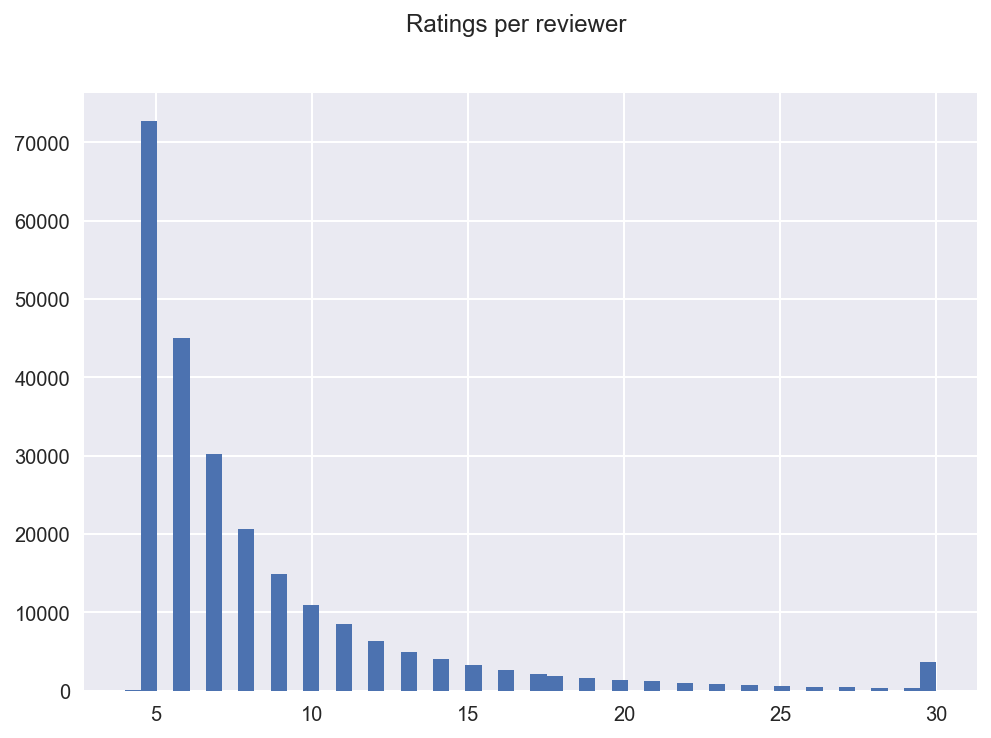

In [11]:
data = df.groupby('reviewerID')['overall'].count().clip(upper=30)
data.hist(bins=50)
plt.suptitle("Ratings per reviewer")
plt.show()

#### Ratings per item

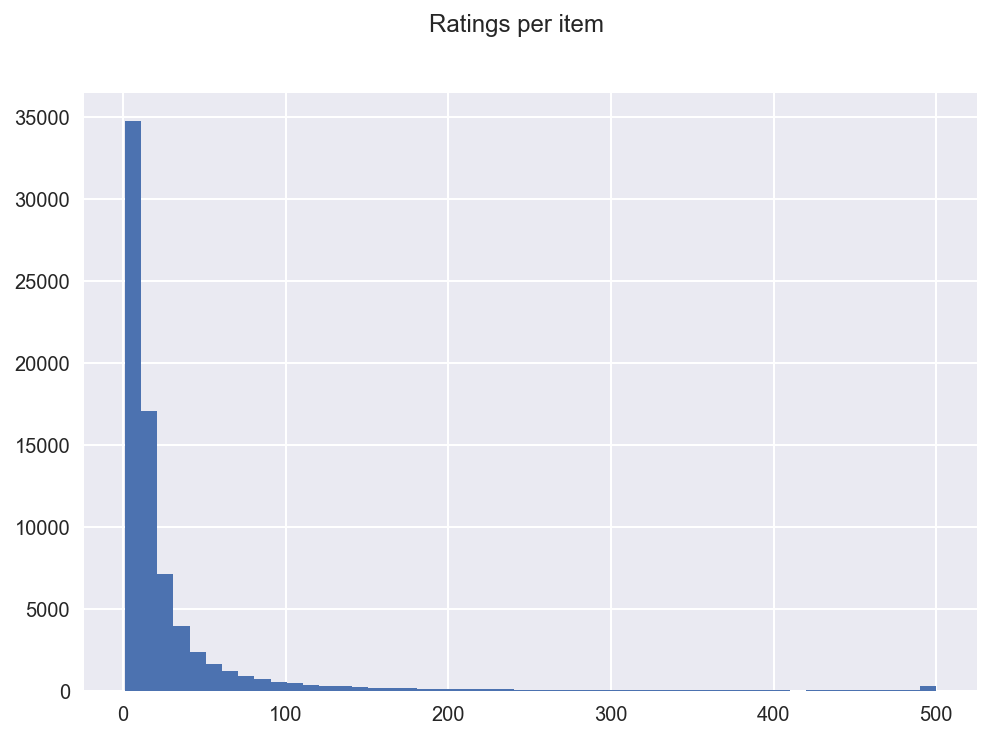

In [13]:
data = df.groupby('asin')['overall'].count().clip(upper=500)
data.hist(bins=50)
plt.suptitle("Ratings per item")
plt.show()

#### Distribution of ratings by products and users

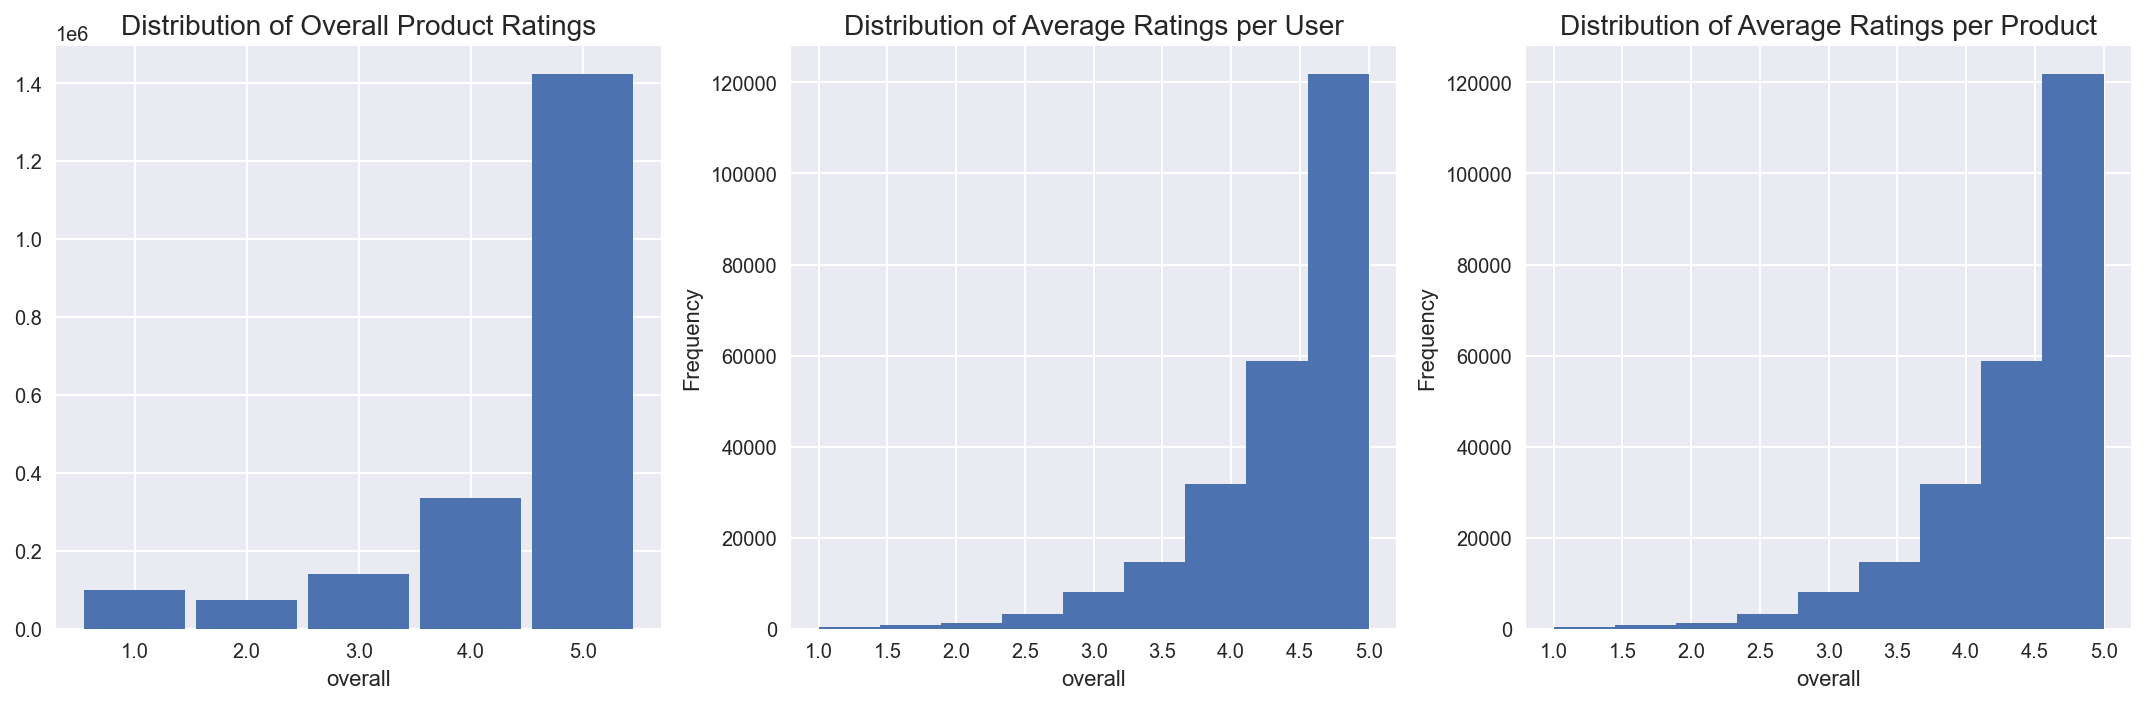

In [14]:
plt.figure(figsize=(15,5))

# Plot distribution of overall product overalls
ax1 = plt.subplot(1,3,1)
df.overall.value_counts().sort_index().plot.bar(width=0.9, ax=ax1)
ax1.set_title('Distribution of Overall Product Ratings', fontsize=14)
ax1.set_xlabel('overall')
plt.xticks(rotation=0)

# Plot user distribution by average overall
ax2 = plt.subplot(1,3,2)
df.groupby('reviewerID').overall.mean().plot(kind='hist', bins=9, ax=ax2)
ax2.set_title('Distribution of Average Ratings per User', fontsize=14)
ax2.set_xlabel('overall')

# Plot distribution of overall overalls among products
ax3 = plt.subplot(1,3,3)
df.groupby('reviewerID').overall.mean().plot(kind='hist', bins=9, ax=ax3)
ax3.set_title('Distribution of Average Ratings per Product', fontsize=14)
ax3.set_xlabel('overall')

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

#### Most popular products

<Figure size 720x360 with 0 Axes>

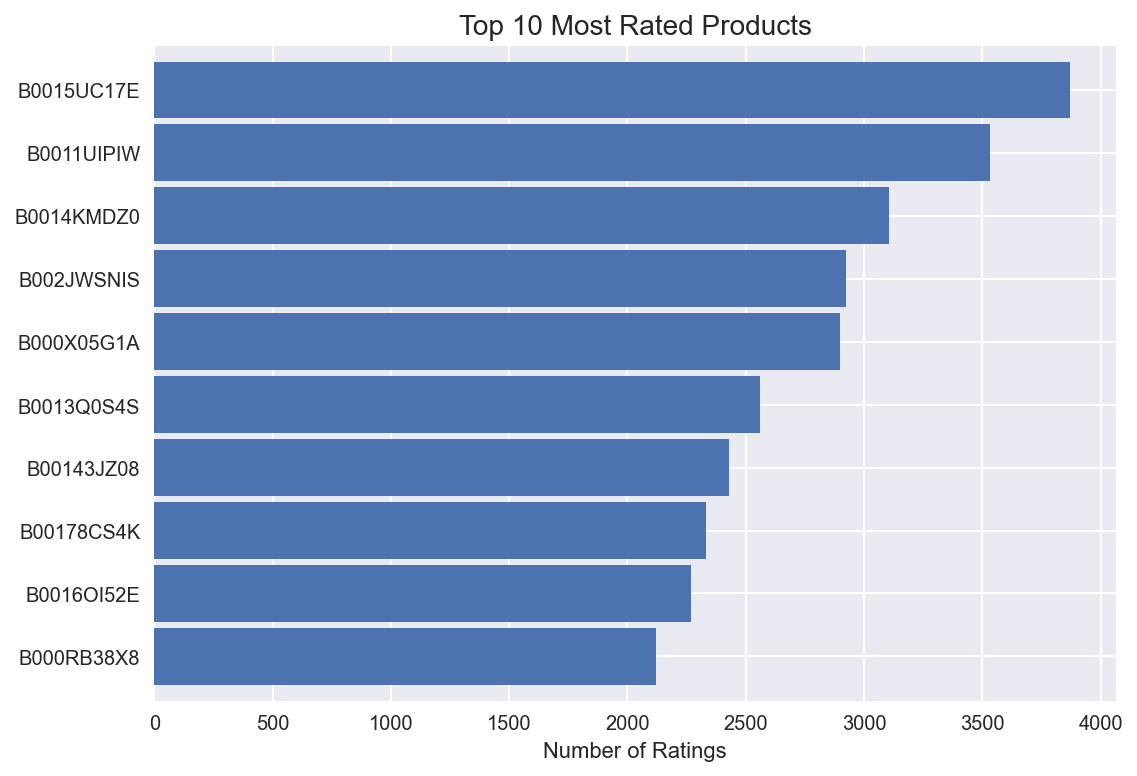

In [15]:
plt.figure(figsize=(10,5))

# Plot 10 most common products purchased
_, ax = plt.subplots()
df.asin.value_counts()[:10].sort_values().plot(kind='barh', width=0.9)#, ax=ax1)
ax.set_xlabel('Number of Ratings')
ax.set_title('Top 10 Most Rated Products', fontsize=14)

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

#### Further reduce dataset by eliminating rarely rating reviewers and rarely rated items

In [16]:
min_asin_ratings = 200
filter_asin = df['asin'].value_counts() > min_asin_ratings
filter_asin = filter_asin[filter_asin].index.tolist()

min_user_ratings = 10
filter_users = df['reviewerID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['asin'].isin(filter_asin)) & (df['reviewerID'].isin(filter_users))]
print(f'The original data frame shape:\t{df.shape}')
print(f'The new data frame shape:\t{df_new.shape}')

The original data frame shape:	(2070831, 6)
The new data frame shape:	(190068, 6)


###  Train-test split

#### Sort dataframe by unixReviewTime column

In [17]:
df = df_new.copy()
df_temp = df.sort_values('unixReviewTime', axis=0, ascending=True, kind='mergesort', na_position='last', ignore_index=False)
df_temp.reset_index(drop=True, inplace=True)
train = df_temp.iloc[: -int(df.shape[0]/4)]
test = df_temp.iloc[-int(df.shape[0]/4):]

In [18]:
train.tail()

,overall,reviewerID,asin,reviewText,summary,unixReviewTime
142546,5.0,ALFDZKCUT9HJZ,B000NK5VY2,excellent,Five Stars,1483488000
142547,3.0,A1SPGBQ7MX0HFZ,B000NPR2P8,This is a pretty good set but for automotive u...,Good for light work but heavier auto stuff mig...,1483488000
142548,5.0,A2O53SOXDCKE3X,B000NPXJS2,"Would buy again, can never have enough clamps",Five Stars,1483488000
142549,4.0,A1DGSLVMMZ3DSM,B000NPXJS2,Love this product. It's super long! Make sure ...,Good Product,1483488000
142550,2.0,A387L2K1LZ2E10,B000P4W3LU,This is not very good. It is flimsy...really ...,"Flimsy plastic, adjuster and pot aluminum",1483488000


In [19]:
test.head()

,overall,reviewerID,asin,reviewText,summary,unixReviewTime
142551,5.0,A1SHO5KDEAVWYO,B000R8LH3E,Perfect hose. Finally I found a air line that ...,Perfect hose for my garage/shop,1483488000
142552,4.0,A162WTYANR6Y30,B000RB3XBA,Good magnet with expanding shaft.,Magnet,1483488000
142553,5.0,AQ5E531L0AB1U,B000RB38X8,This is just what my husband needed...he loves...,Perfect gift,1483488000
142554,5.0,A3TVW95ALPCQ5K,B000SQS6L6,"Simple, easy to install, and looks good.","Simple, easy to install, and looks good.",1483488000
142555,5.0,AMMM79VK84MK0,B000TGDGLU,Arrived on time and as expected. This is the 3...,I like this product,1483488000


### Sentiment model

#### Join text columns and clean them

In [20]:
train["desc"] = (
    train["reviewText"].astype(str) + " " + train["summary"].astype(str)
)
# Remove html if any
train["desc"] = train["desc"].str.replace(r"(?:\<.*?\>)", " ", regex=True)
# Clean and remove punctuation
train["clean"] = train["desc"].pipe(hero.clean).pipe(hero.remove_punctuation)
# Remove stop words
hero.remove_stopwords(train["clean"])

train["clean"].head()

0    last thing needed another tape measure tired t...
1    two work garage shop really great moving heavy...
2    put base together twice works great could meas...
3    thank stanley fat max truly one kind tape comp...
4    one probably years old older ones lost might s...
Name: clean, dtype: object

#### Calculate sentiment score

#####  Read positive and negative lexicons

In [21]:
pos = {}
with open('./data/positive.txt', 'r', encoding="latin-1") as p:
    pos = set(map(str.strip, p))
neg = {}
with open('./data/negative.txt', 'r', encoding="latin-1") as n:
    neg = set(map(str.strip, n))

#####  Calculate numbers of positive and negative words  in each review

In [22]:
train['pos'] = 0
train['neg'] = 0
for i in train.index:
    for word in train.loc[i,'clean'].split():
        if word in pos:
            train.loc[i,'pos'] += 1
        if word in neg:
            train.loc[i,'neg'] += 1

In [23]:
train[5000:5005]

,overall,reviewerID,asin,reviewText,summary,unixReviewTime,desc,clean,pos,neg
5000,5.0,A35MH4WEUGF0G1,B0016A72CC,This was definitely a good buy. It takes a bi...,Very nice,1319673600,This was definitely a good buy. It takes a bi...,definitely good buy takes bit getting used acc...,8,1
5001,5.0,A3COXRUY6JPML5,B00271N18S,These night lights are very bright for LED lig...,Bright. Light sensor could be somewhat more se...,1319673600,These night lights are very bright for LED lig...,night lights bright led lights perfect use com...,8,1
5002,5.0,A1JFNZ4UAMEZN3,B00002X20N,I purchased a box cutter and figured that some...,To me they are just box cutter blades.,1319760000,I purchased a box cutter and figured that some...,purchased box cutter figured sometime would pr...,0,0
5003,5.0,A1JFNZ4UAMEZN3,B00002X204,I was in need of a box cutter so I got on Amaz...,It is a box cutter.,1319760000,I was in need of a box cutter so I got on Amaz...,need box cutter got amazon com looked saw one ...,2,0
5004,5.0,A22GHD1G3OQTED,B0002YVBC0,This set of bags are nifty for carrying many s...,Nice variety of sizes; too bad they don't make...,1319760000,This set of bags are nifty for carrying many s...,set bags nifty carrying many small items use p...,6,2


In [24]:
train['dif']= np.ceil(((train['pos'] - train['neg'])/(train['pos'] + train['neg'] + 0.01) + 1) *2.5)

In [25]:
train[['overall','dif']].head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
overall,4.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0
dif,1.0,3.0,5.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,5.0,5.0,2.0,4.0,4.0,4.0,5.0,4.0


OBSERVATION: "dif" is quite different from "overall". Starting to doubt if it is useful at all. 

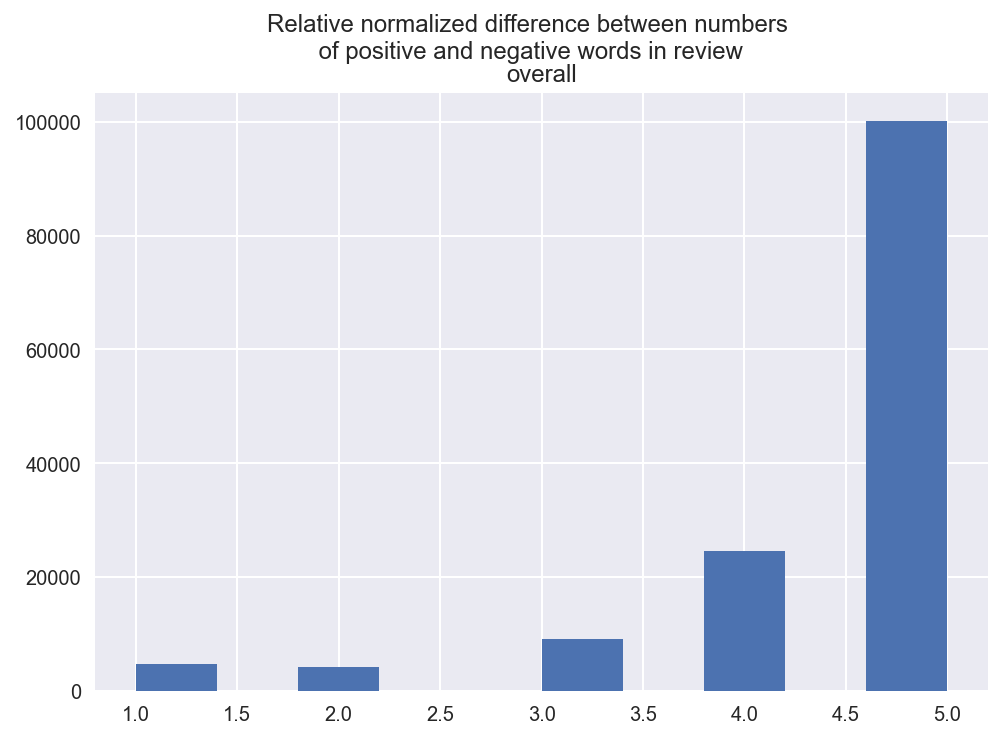

In [26]:
train[['overall']].hist()
plt.suptitle("Relative normalized difference between numbers\n of positive and negative words in review")
plt.show()

##### Compare histograms of overall and calculated dif

Text(0.5, 0.98, 'overall vs dif')

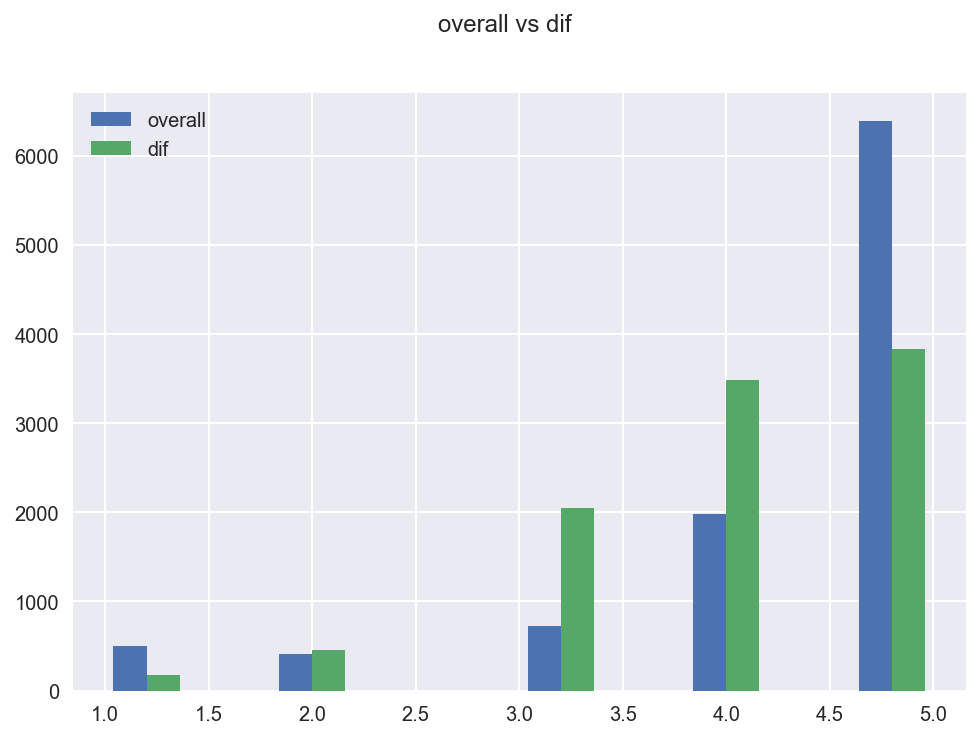

In [27]:
plt.hist(train.loc[:10000][['overall','dif']])
plt.legend(['overall','dif'])
plt.suptitle("overall vs dif")

OBSERVATION: "dif" rating shows milder sloped distribution, giving more of 3 and 4 marks

#### Correlation between overall and dif

In [28]:
train.loc[:100000][['overall','dif']].corr()

,overall,dif
overall,1.0000,0.3633
dif,0.3633,1.0000


OBSERVATION: the correlation is not particulary high due to much lower number of "5"s.

### Surprise

In [29]:
reader = Reader(rating_scale=(1, 5))

In [30]:
test['dif'] = test['overall'] 

#### Set train and test

In [31]:
train_set_from_df = Dataset.load_from_df(train[['reviewerID', 'asin', 'dif']], reader) 
train_set = train_set_from_df.build_full_trainset()

testset = [test.loc[i][['reviewerID', 'asin', 'dif']].to_list() for i in test.index.tolist()]

####  Compare algorithms in cross-validation test

### Let's use KNNBaseline

#### Set algorithm options and cross-validate it

In [48]:
algo = KNNBaseline(n_epochs=3,
               method='als',
               reg_u=10,
               reg_i=150)
cross_validate(algo, train_set_from_df, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.97707744, 0.98269123, 0.97806112]),
 'fit_time': (110.79073524475098, 104.10752582550049, 101.43158984184265),
 'test_time': (12.144397974014282, 16.239140033721924, 20.335378885269165)}

In [49]:
predictions = algo.fit(train_set).test(testset)
rmse(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1006


1.100581831056098

#### Utility functions for prediction results

In [50]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:
        return 0
    

In [51]:
res_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
res_df['Iu'] = res_df.uid.apply(get_Iu)
res_df['Ui'] = res_df.iid.apply(get_Ui)
res_df['err'] = abs(res_df.est - res_df.rui)
best_predictions = res_df.sort_values(by='err')[:10]
worst_predictions = res_df.sort_values(by='err')[-10:]

#### Predictions dataframe

In [52]:
res_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [53]:
res_df

,uid,iid,rui,est,details
0,A1SHO5KDEAVWYO,B000R8LH3E,5.0,4.9546,"{'actual_k': 1, 'was_impossible': False}"
1,A162WTYANR6Y30,B000RB3XBA,4.0,4.4274,"{'actual_k': 0, 'was_impossible': False}"
2,AQ5E531L0AB1U,B000RB38X8,5.0,4.1682,"{'actual_k': 14, 'was_impossible': False}"
3,A3TVW95ALPCQ5K,B000SQS6L6,5.0,4.9115,"{'actual_k': 40, 'was_impossible': False}"
4,AMMM79VK84MK0,B000TGDGLU,5.0,4.2710,{'was_impossible': False}
...,...,...,...,...,...
47512,A10FAGRB34RUCH,B01DCHA3R2,5.0,4.5027,"{'actual_k': 0, 'was_impossible': False}"
47513,A9NZKWA4AVHNP,B01EZV35QU,5.0,3.8457,"{'actual_k': 1, 'was_impossible': False}"
47514,APQ85K5KNZ83X,B01EVYG9N2,5.0,4.4377,"{'actual_k': 0, 'was_impossible': False}"
47515,A27N8SKV3EBVQG,B01FX6JRWM,5.0,4.4578,{'was_impossible': False}


In [54]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
6310,A3IUW081KXD3PE,B014H2OZAC,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,71,0.0
38772,A1S19CC502J0IW,B00002X20N,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,146,0.0
22745,AQFZ3LRUO2IKE,B00IVM1TKO,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",5,234,0.0
38833,A39DIW9IN23IH8,B00B6K4VDK,5.0,5.0,"{'actual_k': 40, 'was_impossible': False}",2,166,0.0
3700,A1PZHJTGE2TS99,B00WNSE4NG,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,135,0.0
22744,A11NG2YCA3TYWH,B00I83462Y,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,79,0.0
3707,A1PZHJTGE2TS99,B0145YWFGI,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,135,0.0
22692,A2UOSX86FZJ4Y9,B000HXT2N6,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",4,241,0.0
38876,A3TXIOS6MU9YR3,B00004T7S1,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,82,0.0
38901,A2I6WVMSP85CYP,B000VJNONU,5.0,5.0,"{'actual_k': 16, 'was_impossible': False}",11,114,0.0


In [55]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
33259,A3HWHCQ0Y90Y66,B006LYHED0,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,180,4.0
38318,ACOV36R272G8F,B000XYOUS6,1.0,5.0,"{'actual_k': 4, 'was_impossible': False}",3,366,4.0
36516,ALEKGNJSD02JZ,B004XWWIT2,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,73,4.0
23929,A3MOA8IT99FG0,B0000302Y8,1.0,5.0,"{'actual_k': 2, 'was_impossible': False}",3,160,4.0
40617,A3I7P2LE602HS2,B002XZLTQO,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",4,74,4.0
888,A2UFDBLOOIIYB8,B00HSWPYIG,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",1,119,4.0
40624,A1CSOAQHFUWGBE,B004Y6V5CI,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",2,300,4.0
37060,A2A59NR09EZ15Q,B00NP2MYO0,1.0,5.0,"{'actual_k': 4, 'was_impossible': False}",4,135,4.0
19382,A32VDEF5IW060B,B002BWORRW,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,165,4.0
47206,A2Q0Z2G1I1B7O7,B00PQ4PJYC,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,105,4.0


In [56]:
res_df[['rui','est']].corr()

,rui,est
rui,1.0000,0.0456
est,0.0456,1.0000


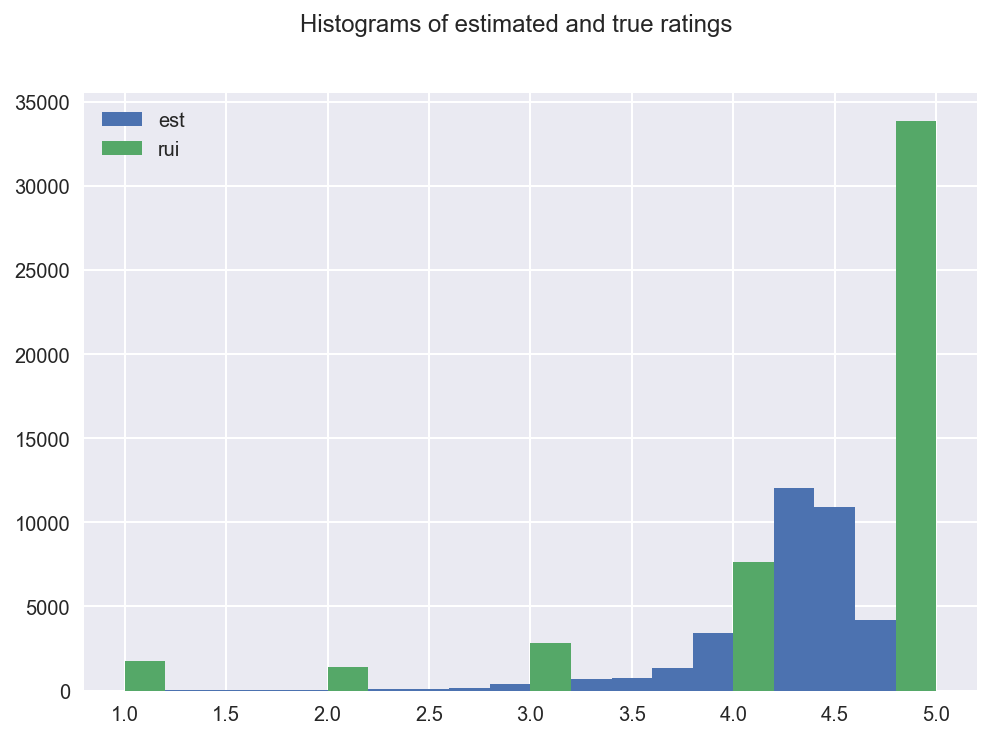

In [57]:
res_df['est'].hist(bins=20)
res_df['rui'].hist(bins=20)
plt.legend(['est','rui'])
plt.suptitle("Histograms of estimated and true ratings")
plt.show()

OBSERVATION: est (predicted rating) has very low correlation with rui ("overall").   
The naive sentiment alogithm gives ratings in a very narrow narrow interval between 4 an 5,   
reflective of values of "overall" that close to median.

### Let's build a classic item-based recommender and compare it with sentiment model as a baseline

#### Set train and test

In [58]:
train_set_from_df = Dataset.load_from_df(train[['reviewerID', 'asin', 'overall']], reader) #.iloc[:50000]
train_set = train_set_from_df.build_full_trainset()

testset = [test.loc[i][['reviewerID', 'asin', 'overall']].to_list() for i in test.index.tolist()]

#### Set algorithm options and cross-validate it

In [59]:
algo = KNNBaseline(n_epochs=3,
               method='als',
               reg_u=10,
               reg_i=150)
cross_validate(algo, train_set_from_df, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.92204186, 0.93151809, 0.94251245]),
 'fit_time': (109.33018589019775, 92.90473294258118, 112.21035385131836),
 'test_time': (10.905472993850708, 9.564796924591064, 10.716333866119385)}

#### Predict results

In [60]:
predictions = algo.fit(train_set).test(testset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [61]:
rmse(predictions)

RMSE: 1.0380


1.0380166109277742

In [62]:
res_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
res_df['Iu'] = res_df.uid.apply(get_Iu)
res_df['Ui'] = res_df.iid.apply(get_Ui)
res_df['err'] = abs(res_df.est - res_df.rui)
best_predictions = res_df.sort_values(by='err')[:10]
worst_predictions = res_df.sort_values(by='err')[-10:]

In [63]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
8584,A1BYXXIH7BXIHZ,B000X1NZPI,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",4,104,0.0
37689,A2NM3OR66LK5HE,B00132H4OE,5.0,5.0,"{'actual_k': 6, 'was_impossible': False}",5,84,0.0
37693,A3AB551HAJPXGC,B0010DHFTK,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",1,168,0.0
45238,A2G93HLVITJE6N,B000P6G74M,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,156,0.0
37695,A2NM3OR66LK5HE,B00132H4OE,5.0,5.0,"{'actual_k': 6, 'was_impossible': False}",5,84,0.0
19364,A20SOBVAXWHSQ8,B000TGDGLU,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,94,0.0
22446,A14V5S42XCL7IB,B0009V1WP2,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",4,98,0.0
19361,A38S1KZE0GNT8G,B000O8OTNC,5.0,5.0,"{'actual_k': 4, 'was_impossible': False}",6,77,0.0
37687,A3AB551HAJPXGC,B0010DHFTK,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",1,168,0.0
43613,A1S0P16TIUH3RV,B00HXD2VV8,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,67,0.0


In [64]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
34632,A1V32O52LIZTC9,B017RX1JUM,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,49,4.0
35806,A2PC5WRPDECNJ5,B0009CEKY6,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,150,4.0
1095,A3BZ2A0DCJLM11,B0002YVBC0,1.0,5.0,"{'actual_k': 3, 'was_impossible': False}",4,181,4.0
23759,A5JEO9I6A7X3A,B01FJGQK58,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",6,18,4.0
8134,A2DP2R1R6FT20,B008X3CHKW,1.0,5.0,"{'actual_k': 4, 'was_impossible': False}",3,120,4.0
40405,AQ1FWUP3I93IY,B00J3JSEG6,1.0,5.0,"{'actual_k': 9, 'was_impossible': False}",9,175,4.0
12229,A2P5X7EQPQNNHD,B00396S1Q2,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",1,451,4.0
26992,A3Q4W3A18SWIEL,B00J4FVZU6,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",4,72,4.0
38318,ACOV36R272G8F,B000XYOUS6,1.0,5.0,"{'actual_k': 4, 'was_impossible': False}",3,366,4.0
46357,A1J36II3HJUQA2,B00A97FIG0,1.0,5.0,"{'actual_k': 5, 'was_impossible': False}",9,106,4.0


In [65]:
res_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [66]:
res_df

,uid,iid,rui,est,details
0,A1SHO5KDEAVWYO,B000R8LH3E,5.0,3.0858,"{'actual_k': 1, 'was_impossible': False}"
1,A162WTYANR6Y30,B000RB3XBA,4.0,4.4995,"{'actual_k': 0, 'was_impossible': False}"
2,AQ5E531L0AB1U,B000RB38X8,5.0,4.3956,"{'actual_k': 14, 'was_impossible': False}"
3,A3TVW95ALPCQ5K,B000SQS6L6,5.0,4.9204,"{'actual_k': 40, 'was_impossible': False}"
4,AMMM79VK84MK0,B000TGDGLU,5.0,4.3352,{'was_impossible': False}
...,...,...,...,...,...
47512,A10FAGRB34RUCH,B01DCHA3R2,5.0,4.4585,"{'actual_k': 0, 'was_impossible': False}"
47513,A9NZKWA4AVHNP,B01EZV35QU,5.0,4.1359,"{'actual_k': 1, 'was_impossible': False}"
47514,APQ85K5KNZ83X,B01EVYG9N2,5.0,4.3772,"{'actual_k': 0, 'was_impossible': False}"
47515,A27N8SKV3EBVQG,B01FX6JRWM,5.0,4.7111,{'was_impossible': False}


In [67]:
res_df[['rui','est']].corr()

,rui,est
rui,1.0000,0.1241
est,0.1241,1.0000


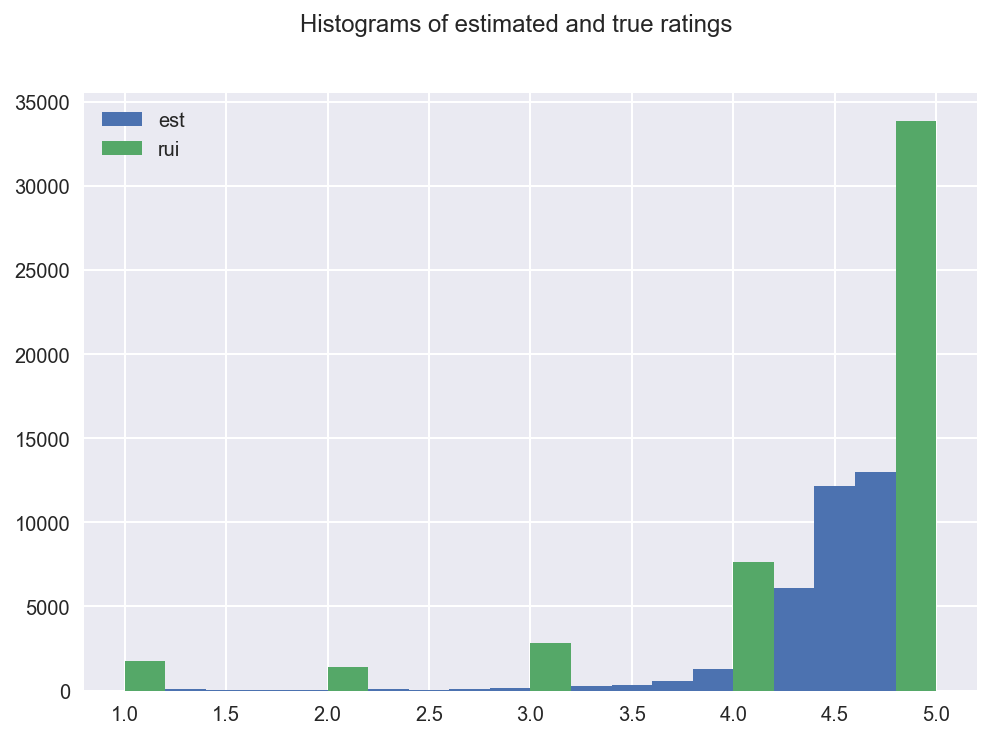

In [68]:
res_df['est'].hist(bins=20)
res_df['rui'].hist(bins=20)
plt.legend(['est','rui'])
plt.suptitle("Histograms of estimated and true ratings")
plt.show()

### Conclusion

Two recommender models show nearly identical, not particularly impressive results. Hyperparameter tuning and playing with other algorithms should definitely improve the practicality of the models. Sentiment-based model can be improved by changing the method to a more sophisticated approach to positive/negative score calculation.